In [1]:
from datetime import datetime
import pandas as pd
import os 
import sys 
from torch.optim import SGD 
import torch.nn as nn
import matplotlib.pyplot as plt 
import numpy as np
import random 
import time

# Load dataset
from load_DataSet_subway_15 import replace_negative, load_data_and_pivot, load_normalized_dataset,load_subway_shp, load_adjacency_matrix
# Data Loader
from DL_utilities import DictDataLoader,Trainer
from utilities import evaluate_metrics
from plotting import plot_loss

In [2]:
# Load Model 
notebook_dir = os.getcwd()
code_dir = os.path.abspath(os.path.join(notebook_dir, '../'))
if code_dir not in sys.path:
    sys.path.insert(0,code_dir)

try : 
    from Ray.Ray_tune.dl_models.CNN_based_model import CNN
    from Ray.Ray_tune.dl_models.RNN_based_model import rnn_perso
    from Ray.Ray_tune.dl_models.GCN_based_model import graphconv
    from Ray.Ray_tune.dl_models.transformer import EncoderTransformer
except : 
    from Ray_tune.dl_models.CNN_based_model import CNN
    from Ray_tune.dl_models.RNN_based_model import rnn_perso
    from Ray_tune.dl_models.GCN_based_model import graphconv
    from Ray_tune.dl_models.transformer import EncoderTransformer

In [3]:
# Init
folder_path = 'data/'
file_name = 'Metro_15min_mar2019_mai2019.csv'
station_location_name = 'ref_subway.csv'
time_step_per_hour=4
H,W,D = 6,1,1
step_ahead = 1
train_prop = 0.6
start,end = datetime(2019,3,16),datetime(2019,6,1)
reindex = pd.date_range(start,end,freq = f'{60/time_step_per_hour}min')
print(f'Number of time-slot: {4*24*(end-start).days}')

Number of time-slot: 7392


## Load DataSet, Feature Vector, Adjacency Matrix, Normalize

In [4]:
# Load data
subway_in,subway_out = load_data_and_pivot(folder_path, file_name, reindex)
df_locations = load_subway_shp(folder_path,station_location_name)
# Pre-processing
subway_in = replace_negative(subway_in,method = 'linear') 
subway_out = replace_negative(subway_out,method = 'linear')

# Set forbidden dates :
# Data from  23_03_2019 14:00:00 to 28_04_2019 12:00:00 included should not been taken into account 
invalid_dates = pd.date_range(datetime(2019,4,23,14),datetime(2019,4,28,14),freq = f'{60/time_step_per_hour}min')

(dataset_in,U_in,Utarget_in) = load_normalized_dataset(subway_in,time_step_per_hour,train_prop,step_ahead,H,D,W,invalid_dates)
(dataset_out,U_out,Utarget_out) = load_normalized_dataset(subway_out,time_step_per_hour,train_prop,step_ahead,H,D,W,invalid_dates)

# colname2indx allow to keep track on the position of a station ('Ampere', 'Brotteaux', ...) within the Tensor
colname2indx_in,indx2colname_in = dataset_in.bijection_name_indx()
colname2indx_out,indx2colname_out = dataset_out.bijection_name_indx()

# Adjacency Matrices : 
A_dist = load_adjacency_matrix(dataset_in, type = 'distance', df_locations = df_locations, treshold = 0.3)
A_neighbor = load_adjacency_matrix(dataset_in, type = 'adjacent')
A_corr = load_adjacency_matrix(dataset_in, type = 'correlation')

print(f'U shape: {U_in.shape} and Target shape: {Utarget_in.shape}')

U shape: torch.Size([5663, 40, 8]) and Target shape: torch.Size([5663, 40, 1])


### Outliers qui posent problèmes 

In [5]:
if False: 
    dic_maxi = {}
    for c in subway_in:
        df_tmps = pd.DataFrame()
        d = subway_in[[c]]
        for k,(indx,flow) in enumerate(d.iterrows()):
            if ((flow[c] > 1200) and not(indx in invalid_dates)) :
                concat = d.iloc[k-3:k+3,:]
                df_tmps = pd.concat([df_tmps,concat])

        dic_maxi[c] = df_tmps
    

## DataLoader, train,valid,test split

In [6]:
# Parameter
valid_prop = 0.2
batch_size = 32

dataset = dataset_in
U,Utarget = U_in, Utarget_in

In [7]:
# Generate a dataloader object, which propose different validation (classic, K-fold Cross ...). 
# data_loader is a dictionnary containing train, valid, and test dataset
data_loader_obj = DictDataLoader(U,Utarget,train_prop,valid_prop,validation = 'classic', shuffle = True)
data_loader = data_loader_obj.get_dictdataloader(batch_size)

## Load and Train Model 

In [8]:
# Parameters of the dataset : 
L = H+W+D 

# Hyperparameters
epochs = 10
lr = 1e-5
momentum = 0.99 # 0.9


#Config all models : 
C_outs = [32,1]


# Config cnn: 
H_dims = [16,32,16,32,16]
c_in = 1

# Config lstm/rnn/gru : 
num_layers = 3
h_dim = 64
bidirectional = False

# Model name: 
model_name = 'cnn'
model_name = 'lstm'
model_name = 'gru'
model_name = 'transformer'

In [9]:
embed_dim = 64
n_head = 4  # 4 heads of dimensions 16, which will be concatenated
d_ff = 32   # apparement plutôt > embed_dim
num_layer = 2
dropout = 0.3
c_out = 1


Layer Normalization : s'assure que pour un input doné, tout les neuronnes d'une même couche ont la même distribution sur toutes les feature 

Choose Model :

In [10]:
# Model
def choose_model(model_name):
    if model_name == 'cnn':
        #model = cnn_perso(c_in=1, h_dim=h_dim, c_out=1, kernel_size = (2,), L=L, padding = 0)
        model = CNN(c_in, H_dims, C_outs, kernel_size = (2,), L=L, padding = 1)
    if model_name == 'lstm':
        model = RNN(L,h_dim,C_outs, num_layers,dropout = 0.0,bidirectional = bidirectional,lstm = True, gru = False)
    if model_name == 'gru':
        model = RNN(L,h_dim,C_outs, num_layers,dropout = 0.0,bidirectional = bidirectional,lstm = False, gru = True)
    if model_name == 'transformer':
        model = EncoderTransformer(c_out,L,embed_dim,d_ff,n_head,num_layers, dropout)
    return(model)



# Shape of a batch of sample: 

In [11]:
print(f"x_b shape: {next(iter(data_loader['train']))[0].size()}, \ny_b shape: {next(iter(data_loader['train']))[1].size()}")

x_b shape: torch.Size([32, 40, 8]), 
y_b shape: torch.Size([32, 40, 1])


## Get Config

In [12]:
config = dict(model_name= 'transformer', lr = [1e-4],epochs = [50], input_dim = L, embed_dim = [256,512], n_head = [8,16], d_ff = [256,512], num_layers = [1,2,4], dropout = 0.3)

def random_config(config):
    for key in config.keys():
        if type(config[key]) != list:
            globals()[key] = config[key]
        else:
            ind = random.randint(0,len(config[key])-1)
            globals()[key] = config[key][ind]

# Train Valid and Test

model_name_transformer_lr_0.0001_epochs_50_input_dim_8_embed_dim_256_n_head_8_d_ff_256_num_layers_4_dropout_0.3
start training


/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([5, 40, 1])) that is different to the input size (torch.Size([5, 1, 40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([13, 40, 1])) that is different to the input size (torch.Size([13, 1, 40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 
 min\epoch : 0.34


/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 1, 40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 1, 40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


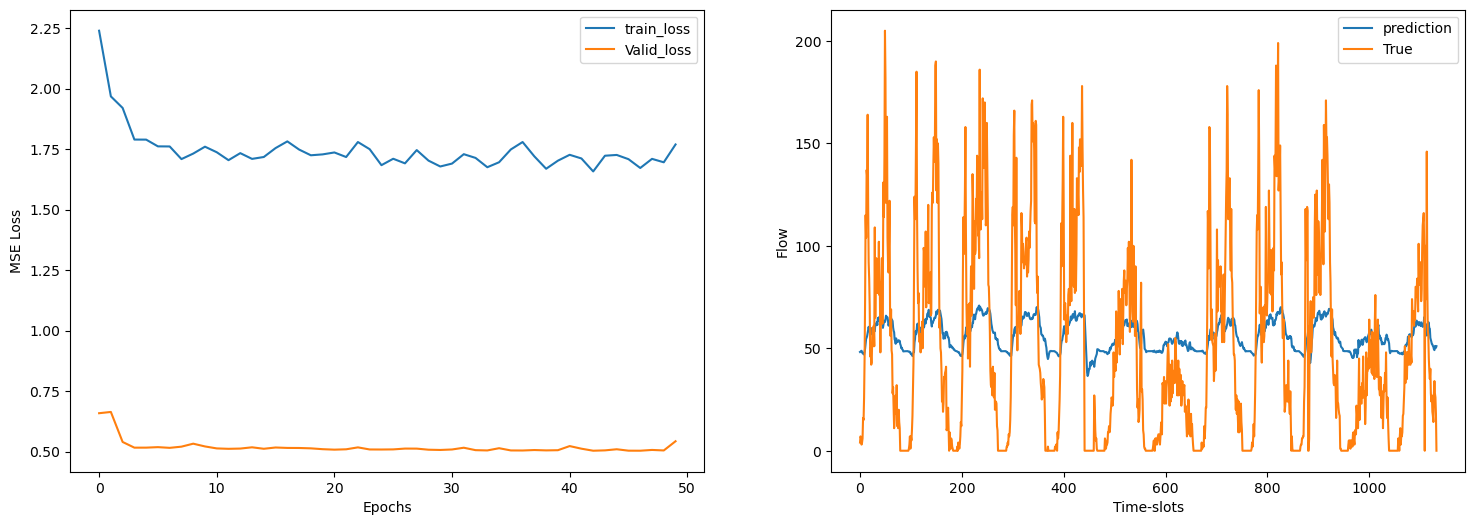

model_name_transformer_lr_0.0001_epochs_50_input_dim_8_embed_dim_256_n_head_16_d_ff_256_num_layers_4_dropout_0.3
start training
epoch: 0 
 min\epoch : 0.38


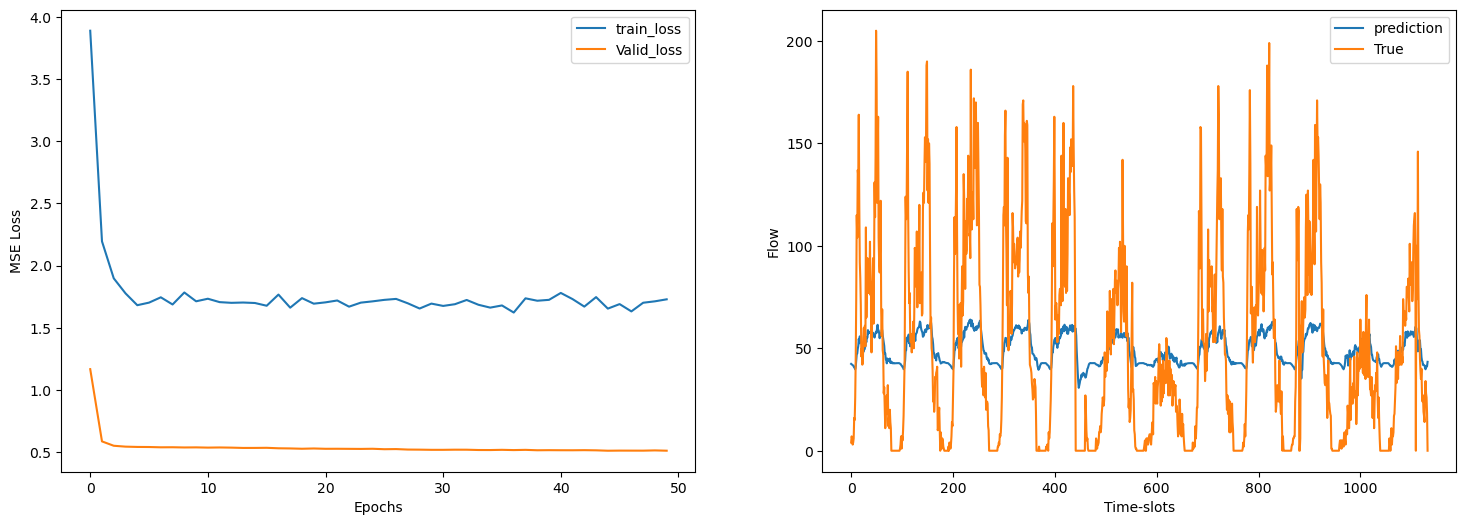

In [14]:
for sample in range(2):
    #for H_dims in [[16,32,16,32,16]]:
        #for C_outs in [[32,1]]:
            #print(f"model: {model_name} with: \n  lr: {lr} \n H_dim: {'_'.join(list(map(str,H_dims)))} \n C_outs: {'_'.join(list(map(str,C_outs)))}")
    random_config(config)
    print('_'.join([f'{k}_{globals()[k]}' for k in config.keys()]))
    model = choose_model(model_name)
    optimizer = SGD(model.parameters(),lr=lr,momentum = momentum)
    loss_function = nn.MSELoss()  

    # Training and validation 
    trainer = Trainer(model,data_loader,epochs,optimizer,loss_function,scheduler = None)
    trainer.train_and_valid(mod = 50)

    # Testing 
    (test_pred,Y_true,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])

    
    plot_loss(trainer,test_pred,Y_true)

J'ai fait un test de prediction de série temporelle assez simple (CNN,LSTM). Je remarque que pour de la prédiction de station metro (40 station)  les modèle simple fonctionnent le mieux.
Ou alors, il faut vraiment mettre un grand nombre d'epoch, car beaucoup trop de paramètre à calibrer. 
Quand on regarde la serie H_dim = [16,32,16], on a un 'saut' sur la loss après 20 epochs, on dirait que cela ne décroit pas avec le même profil que les autres.

Output module : Une seule couche linéaire (avec c_out = 1), plutôt que deux linéaire en série.

Meilleurs résultats avec : 2 CNN 32,32   / 1 seul CNN 16 / 
lr = 1e-4 meilleur que 1e-5 ici (ca rdemande un entrainement plus long)

model: cnn with: 
  lr: 0.0001 
 H_dim: 16 
 C_outs: 1


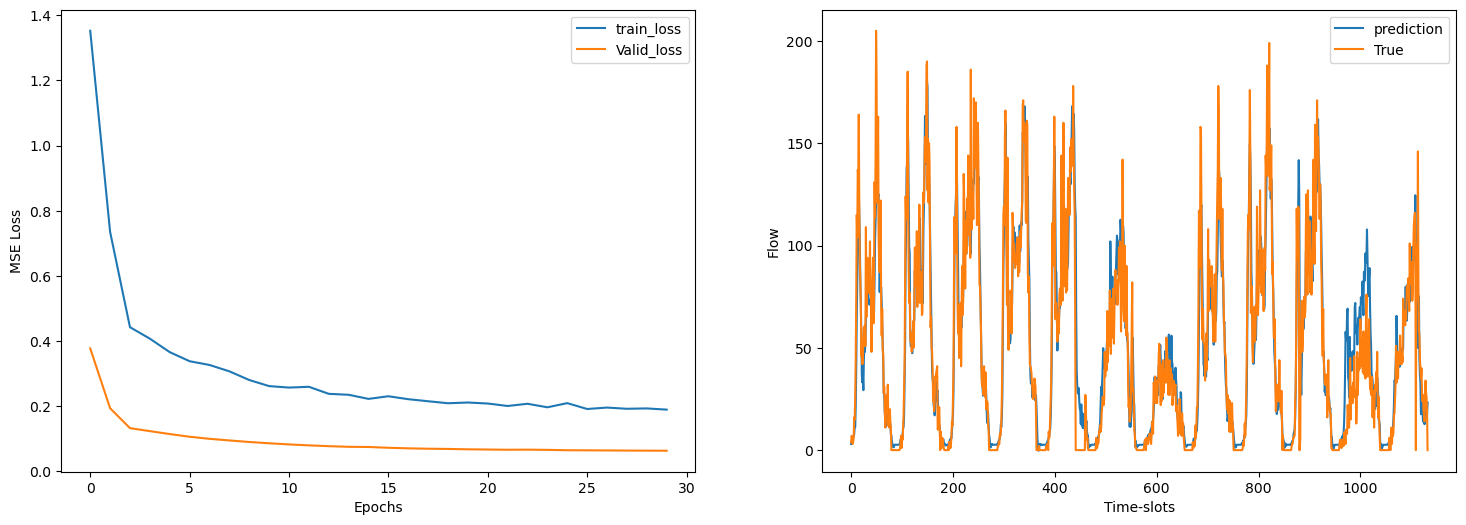

model: cnn with: 
  lr: 0.0001 
 H_dim: 16 
 C_outs: 32_1


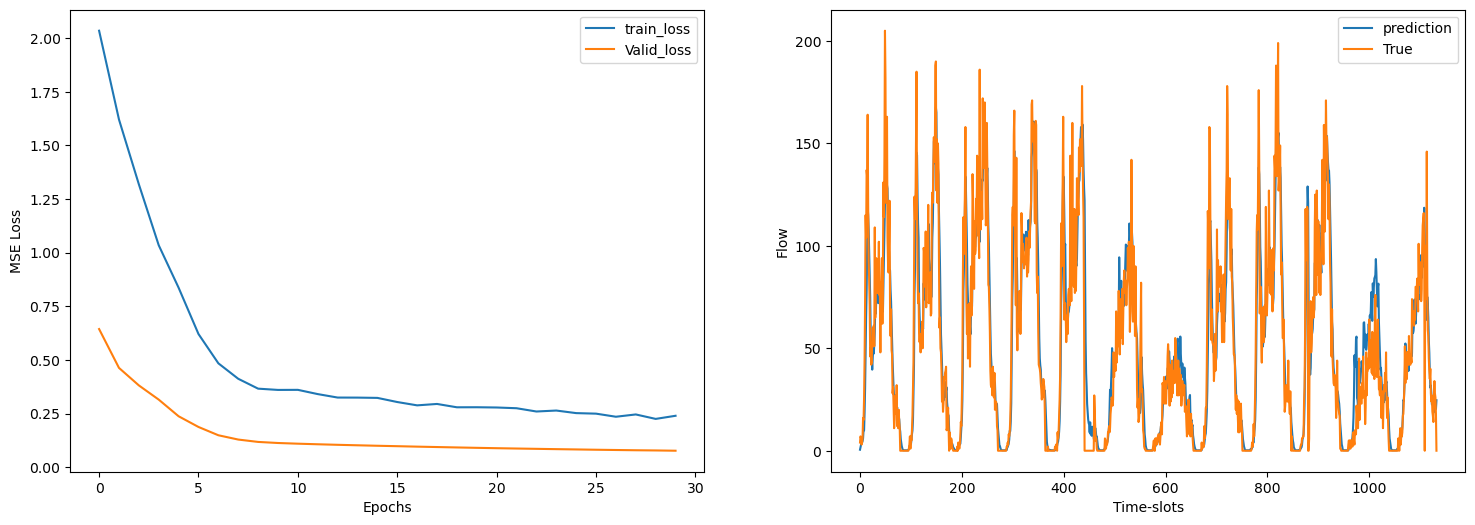

model: cnn with: 
  lr: 0.0001 
 H_dim: 16 
 C_outs: 16_1


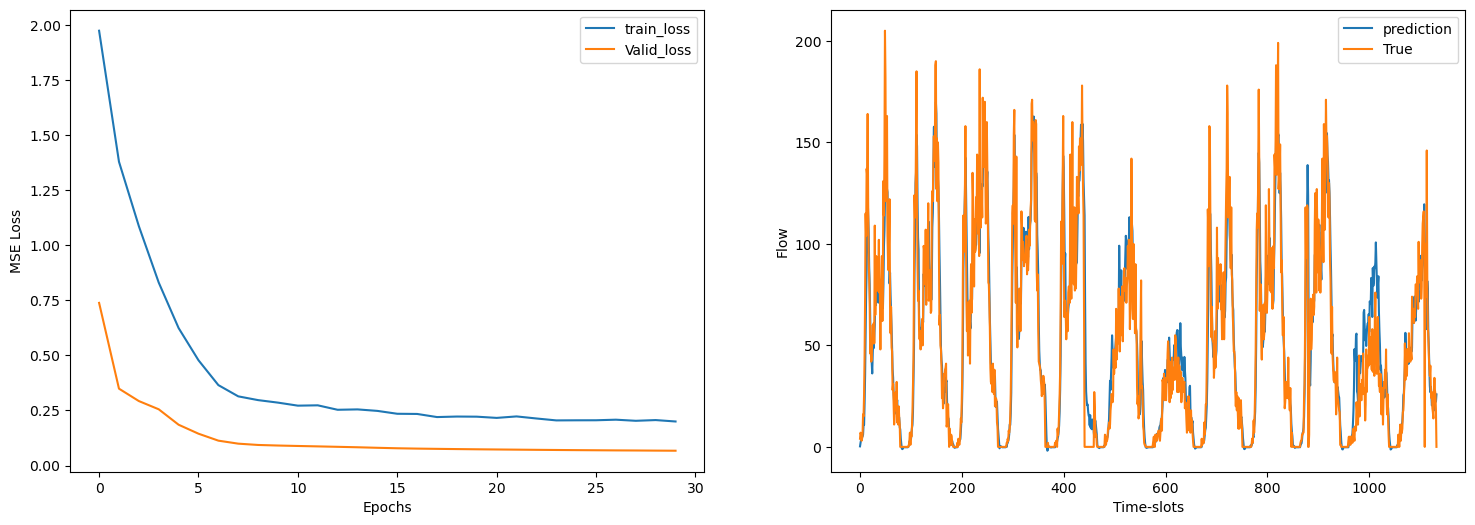

model: cnn with: 
  lr: 0.0001 
 H_dim: 32 
 C_outs: 1


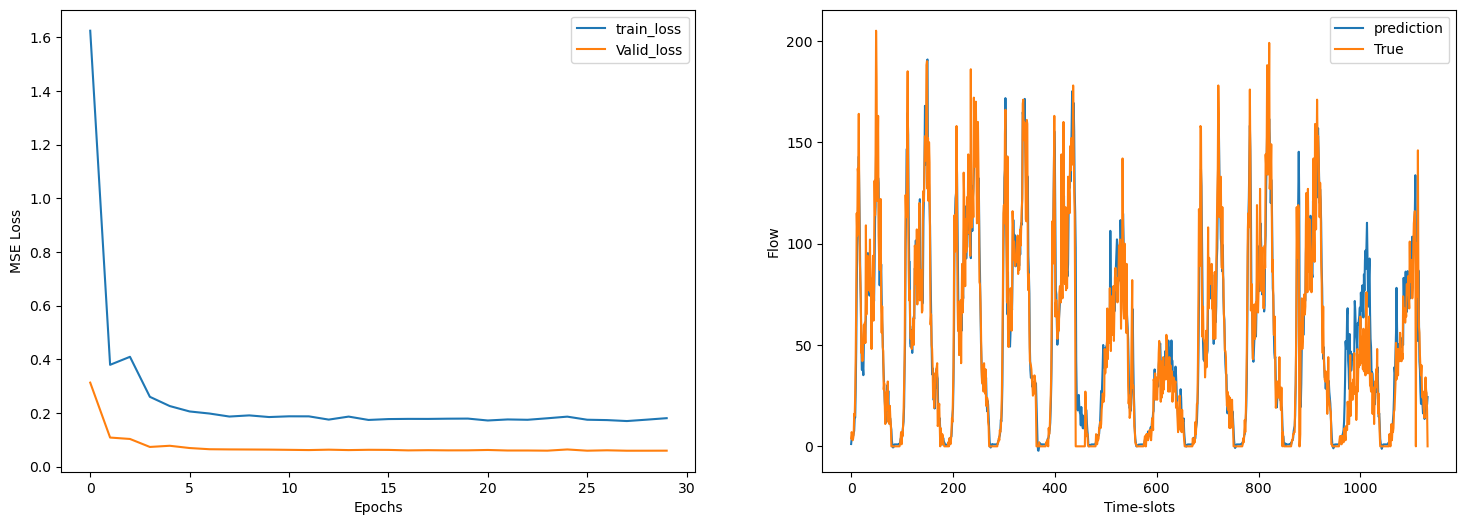

model: cnn with: 
  lr: 0.0001 
 H_dim: 32 
 C_outs: 32_1


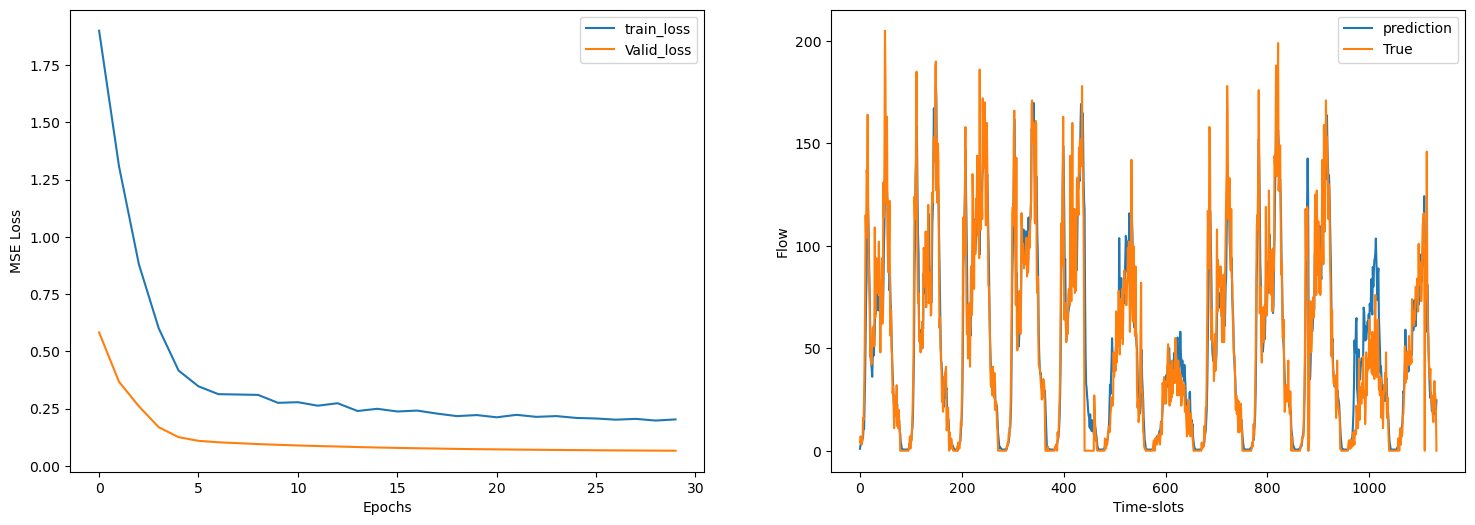

model: cnn with: 
  lr: 0.0001 
 H_dim: 32 
 C_outs: 16_1


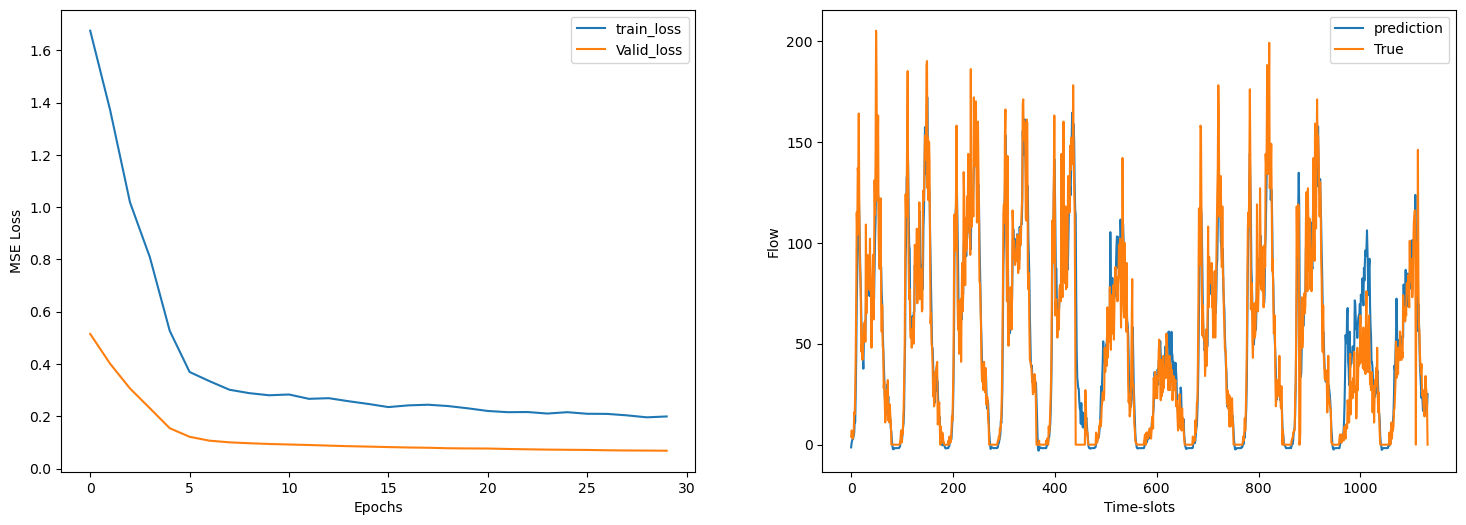

model: cnn with: 
  lr: 0.0001 
 H_dim: 16_32 
 C_outs: 1


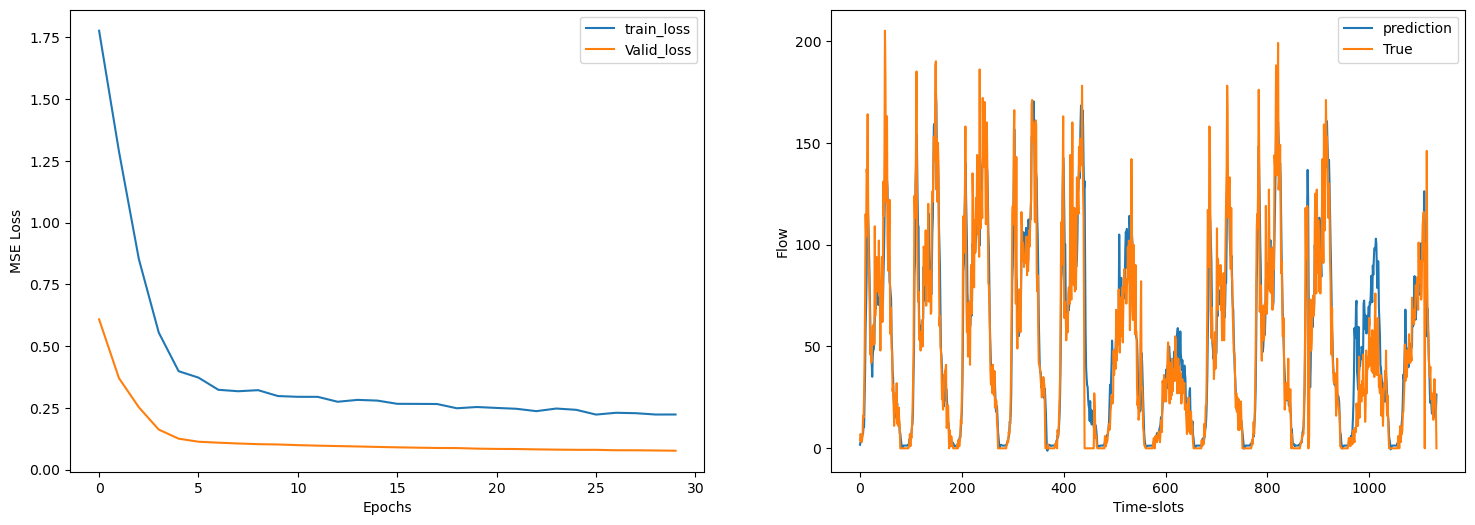

model: cnn with: 
  lr: 0.0001 
 H_dim: 16_32 
 C_outs: 32_1


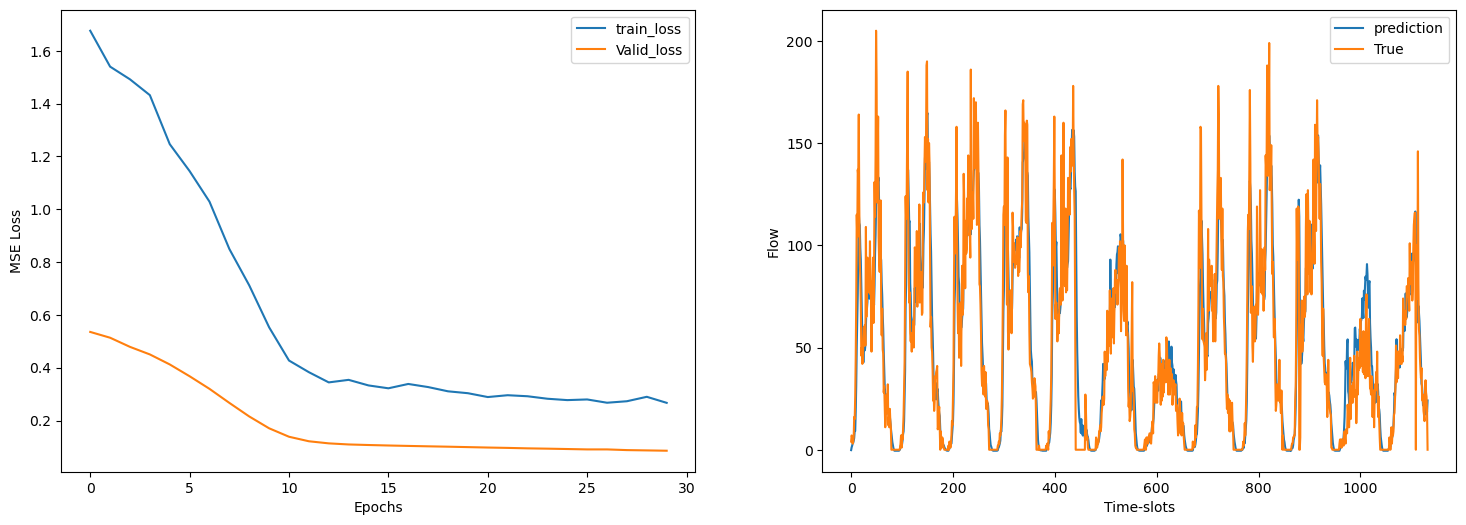

model: cnn with: 
  lr: 0.0001 
 H_dim: 16_32 
 C_outs: 16_1


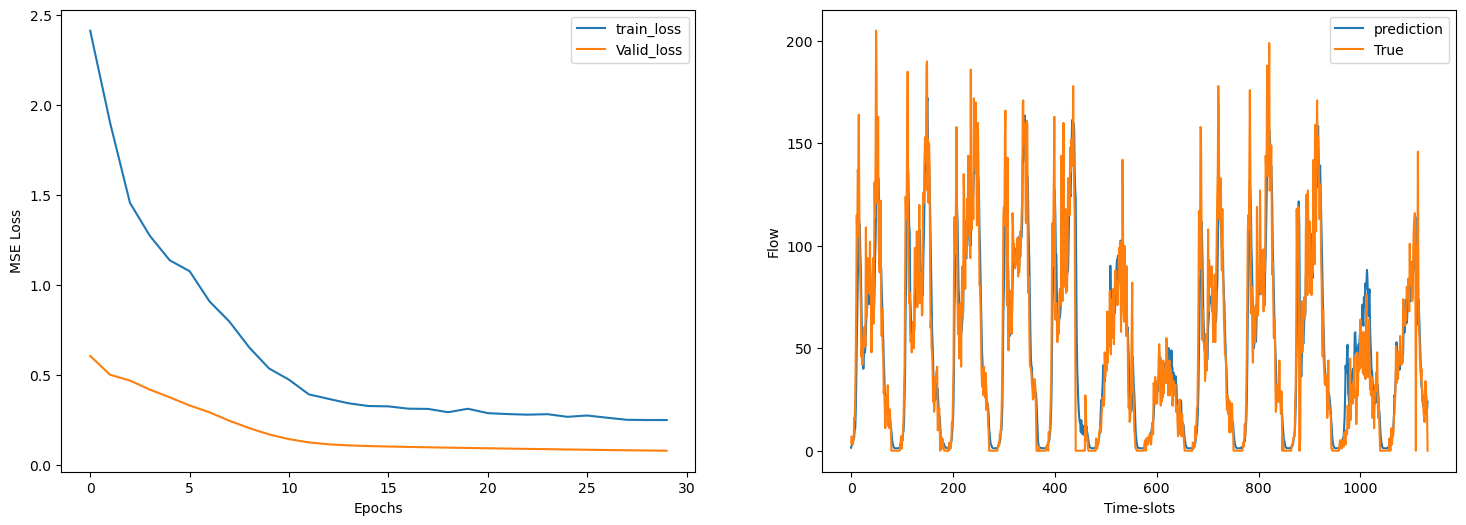

model: cnn with: 
  lr: 0.0001 
 H_dim: 32_32 
 C_outs: 1


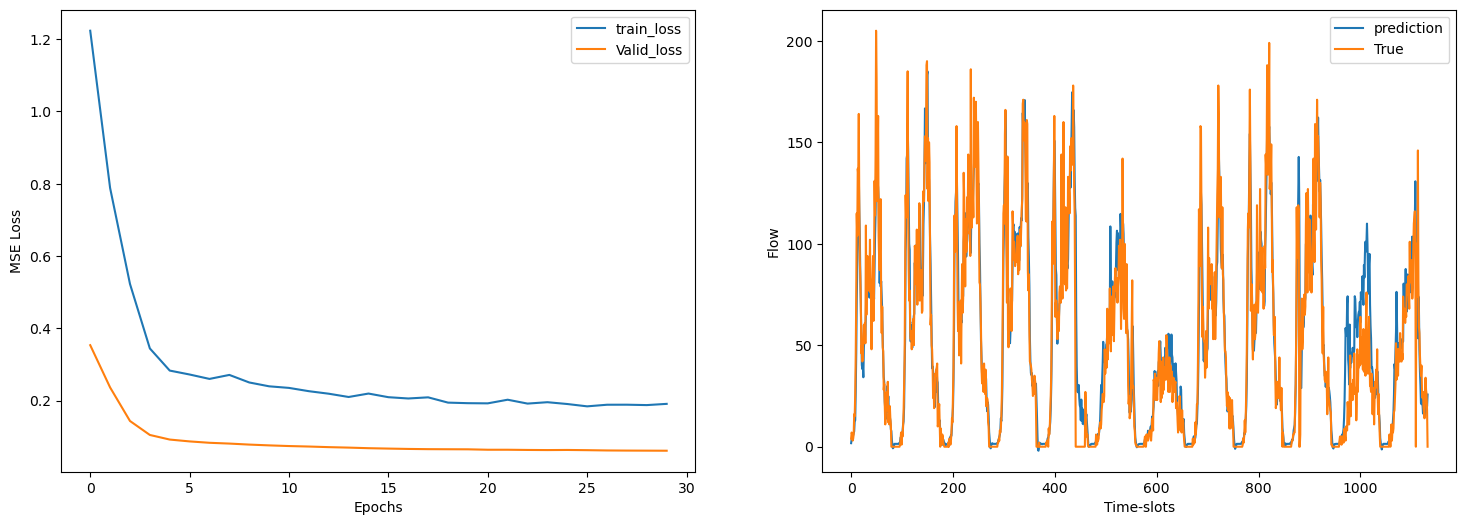

model: cnn with: 
  lr: 0.0001 
 H_dim: 32_32 
 C_outs: 32_1


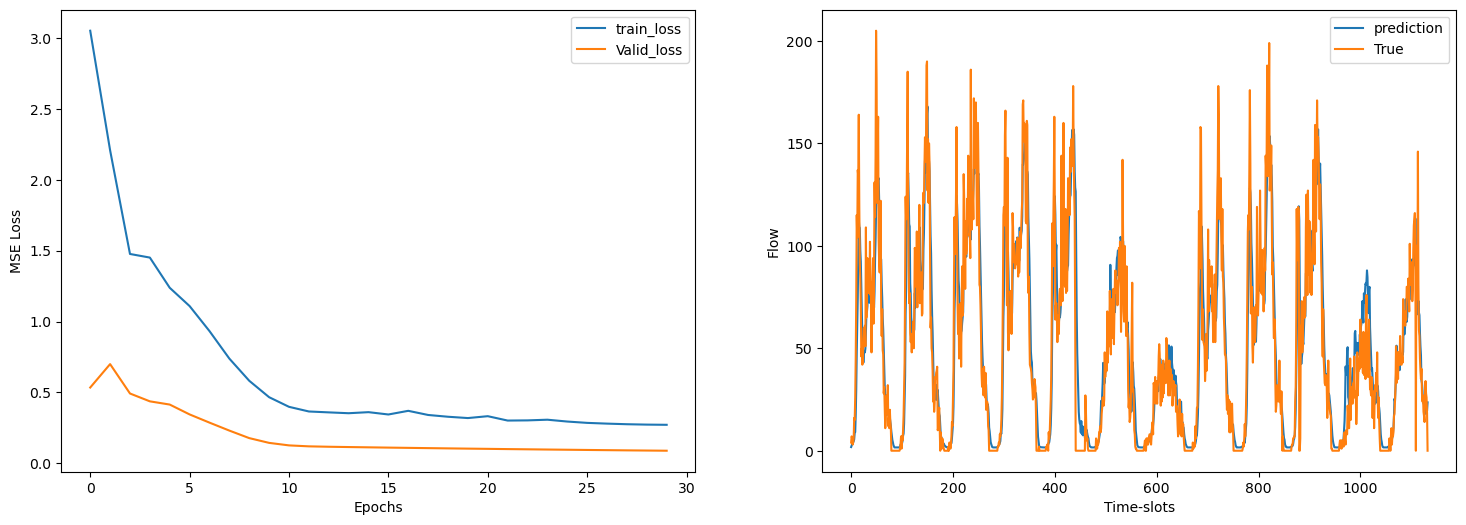

model: cnn with: 
  lr: 0.0001 
 H_dim: 32_32 
 C_outs: 16_1


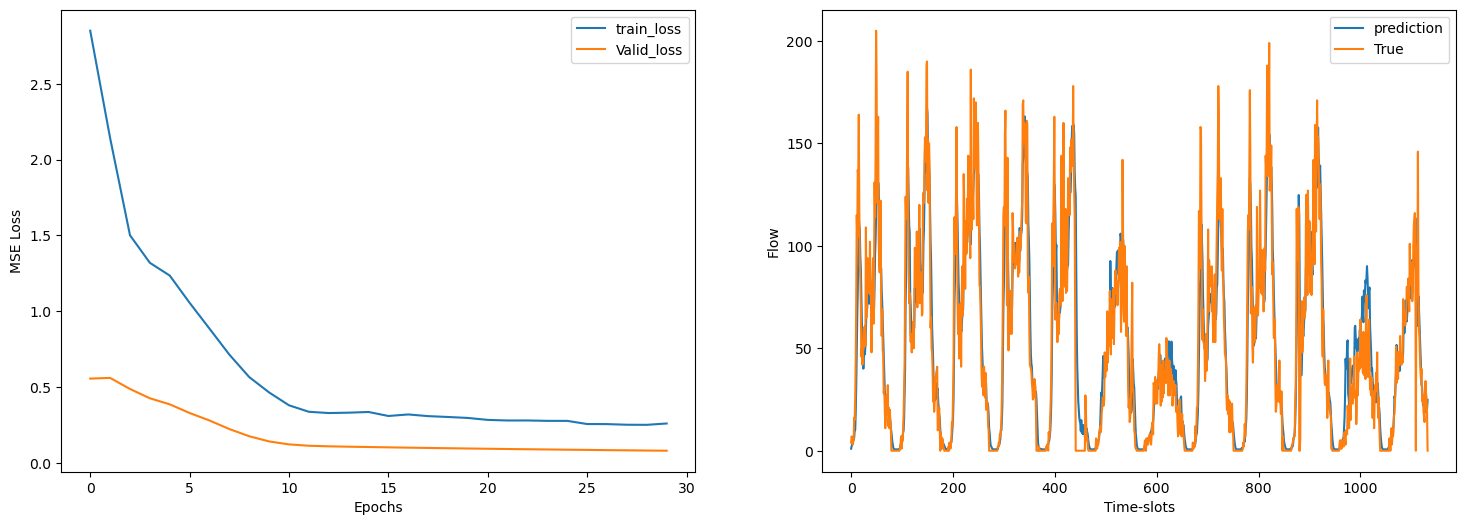

model: cnn with: 
  lr: 0.0001 
 H_dim: 16_32_16 
 C_outs: 1


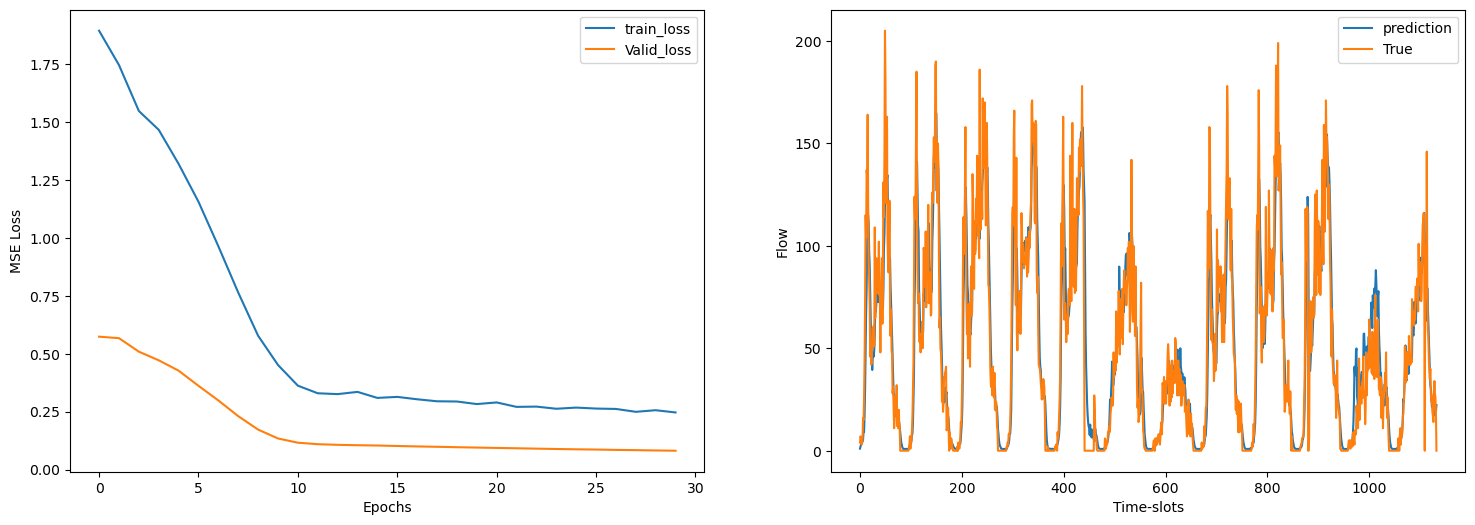

model: cnn with: 
  lr: 0.0001 
 H_dim: 16_32_16 
 C_outs: 32_1


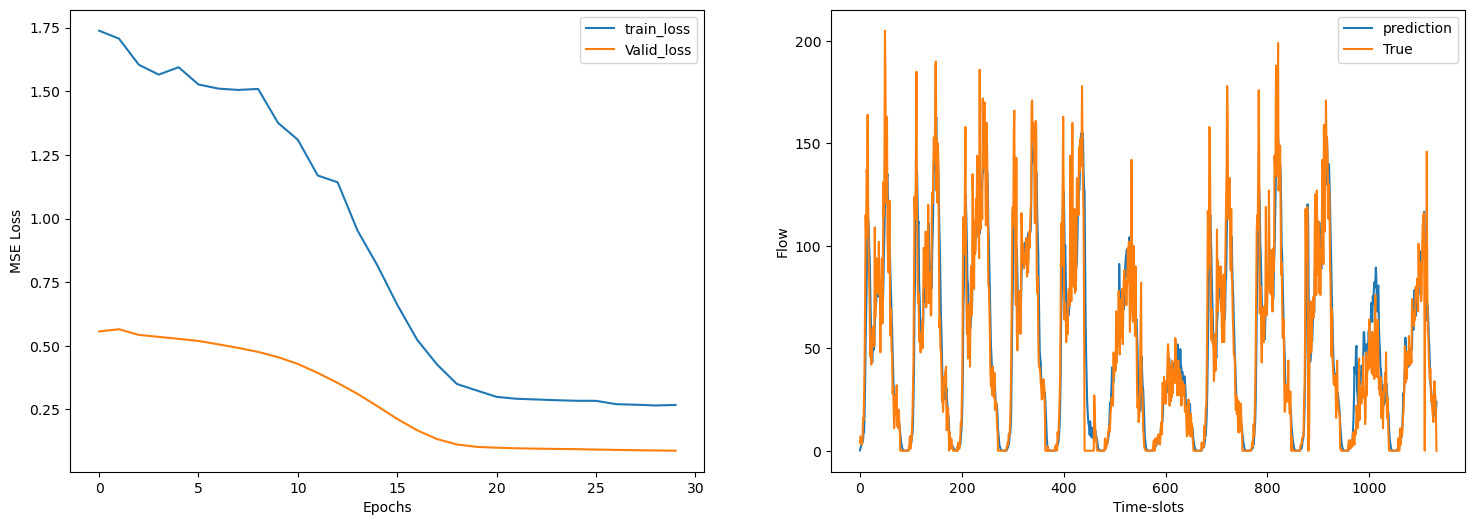

model: cnn with: 
  lr: 0.0001 
 H_dim: 16_32_16 
 C_outs: 16_1


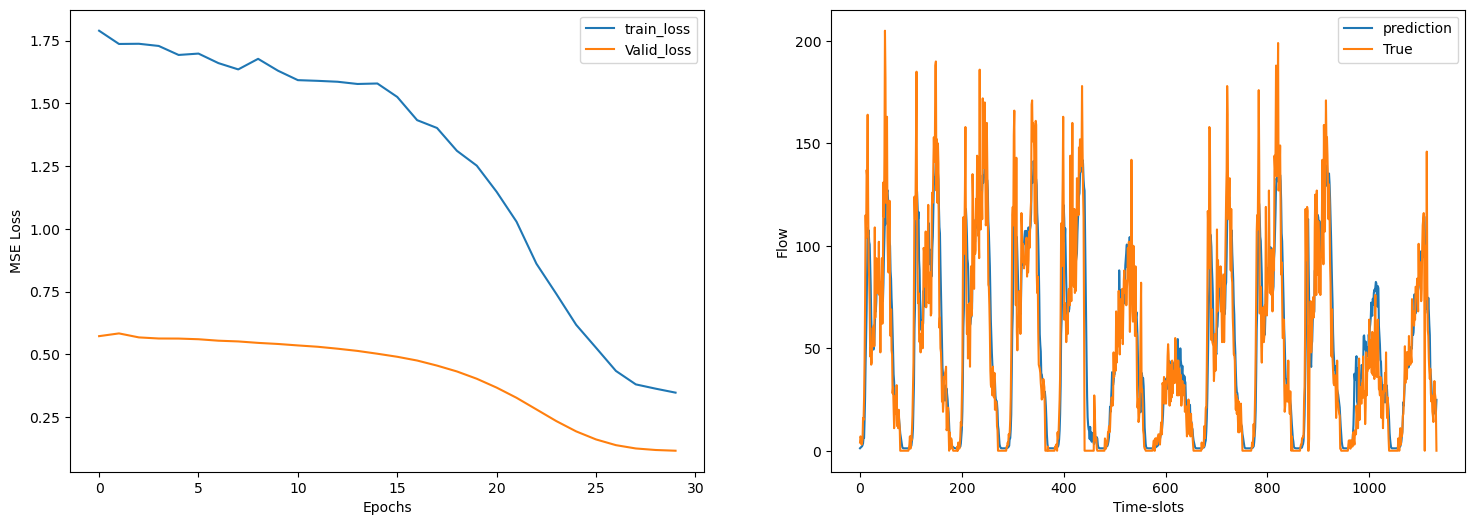

model: cnn with: 
  lr: 1e-05 
 H_dim: 16 
 C_outs: 1


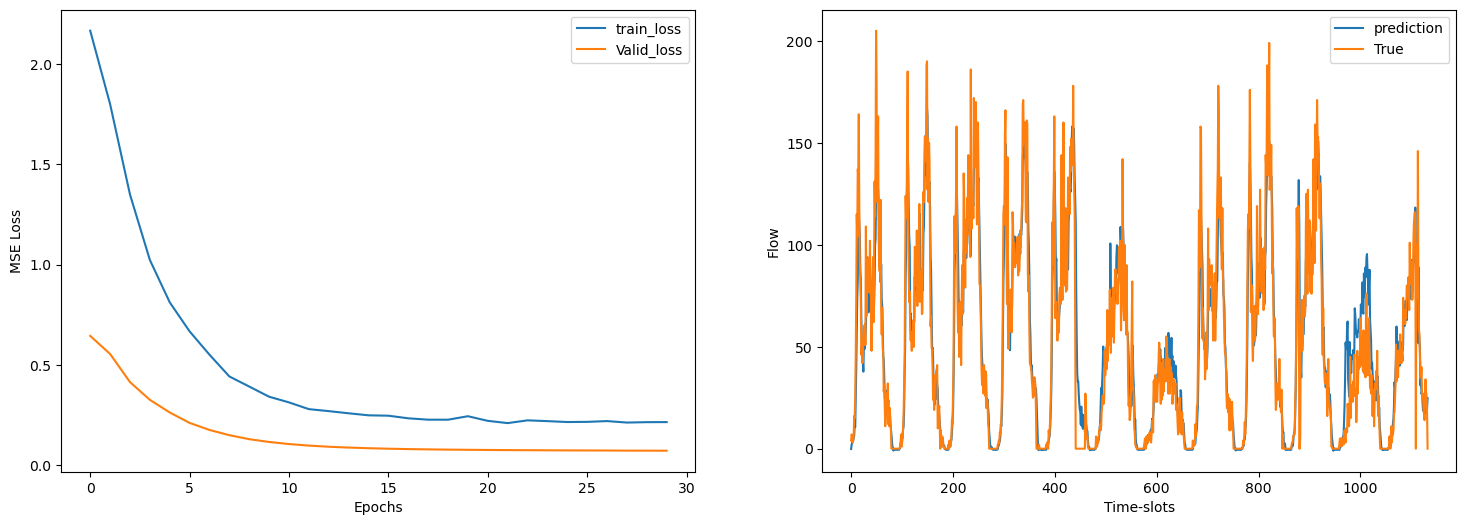

model: cnn with: 
  lr: 1e-05 
 H_dim: 16 
 C_outs: 32_1


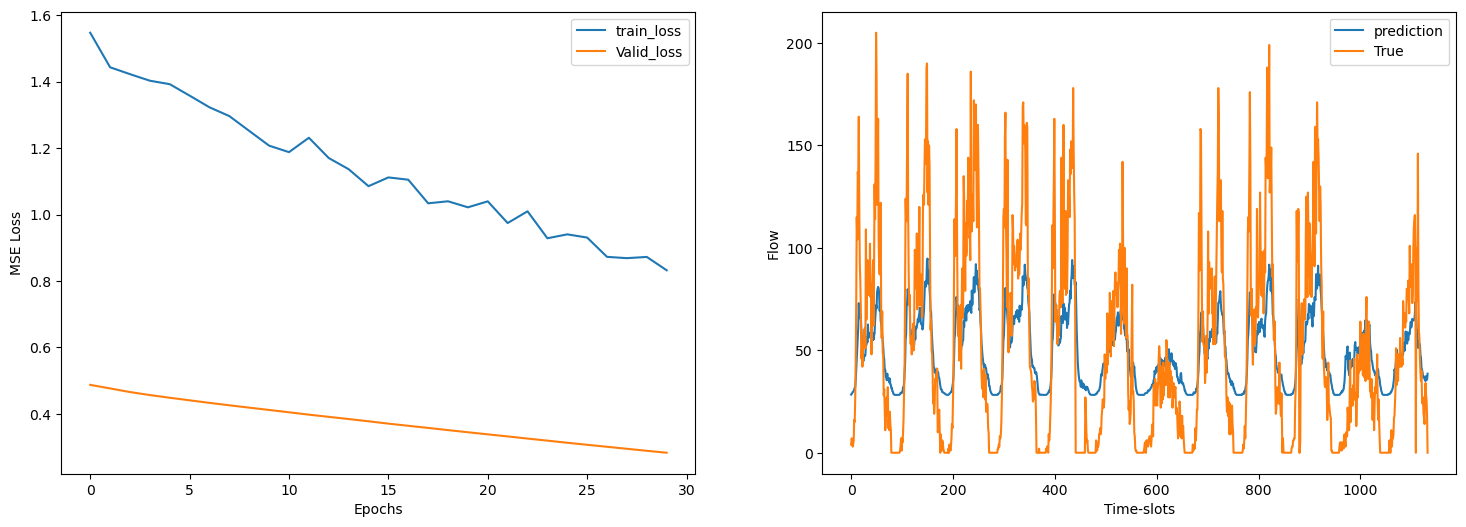

model: cnn with: 
  lr: 1e-05 
 H_dim: 16 
 C_outs: 16_1


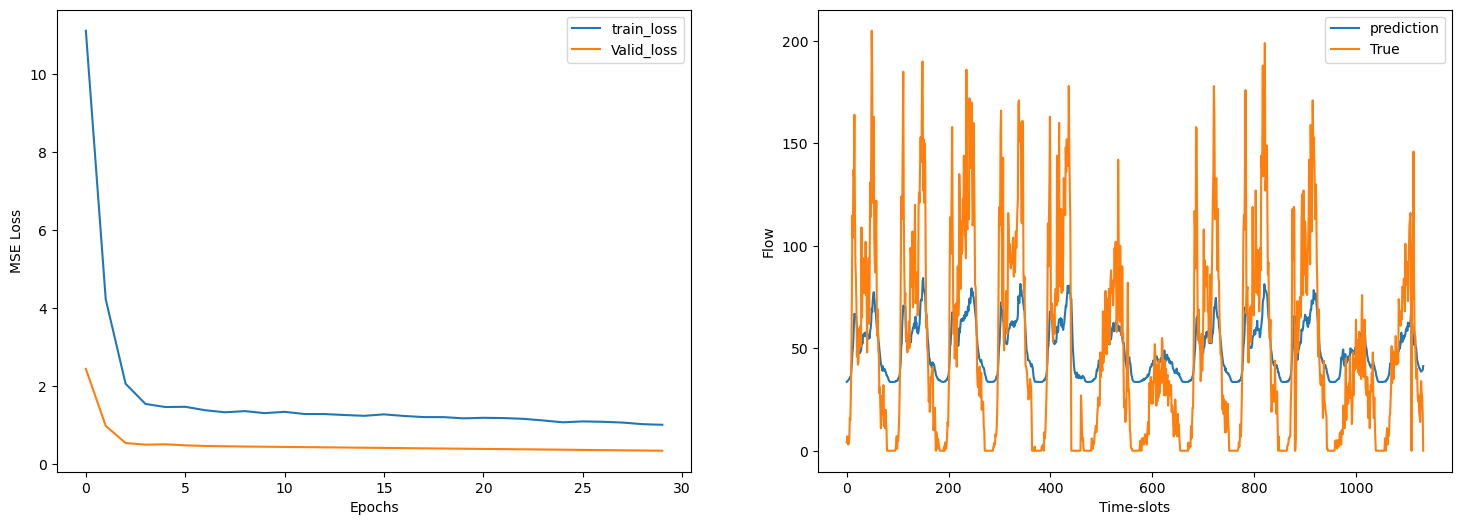

model: cnn with: 
  lr: 1e-05 
 H_dim: 32 
 C_outs: 1


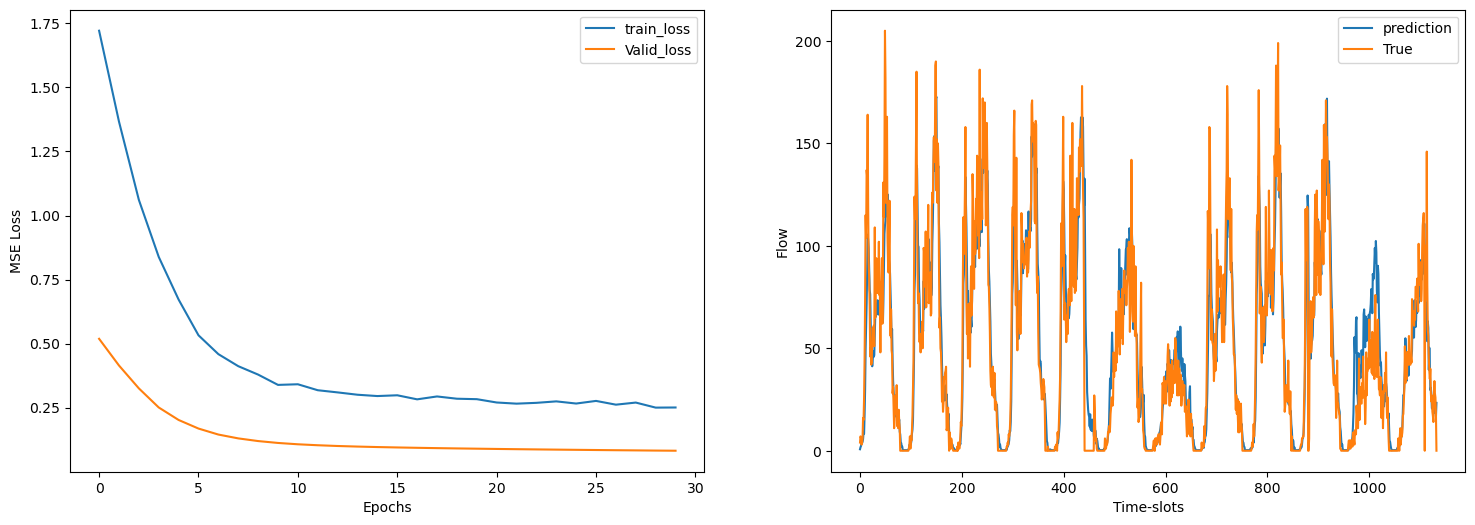

model: cnn with: 
  lr: 1e-05 
 H_dim: 32 
 C_outs: 32_1


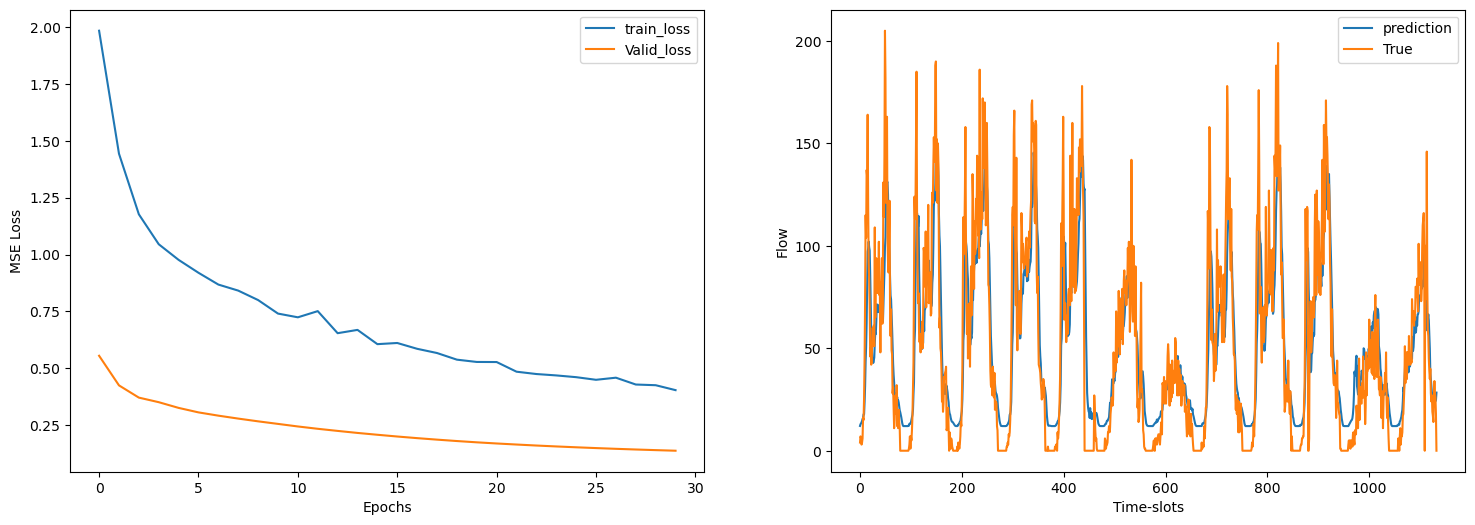

model: cnn with: 
  lr: 1e-05 
 H_dim: 32 
 C_outs: 16_1


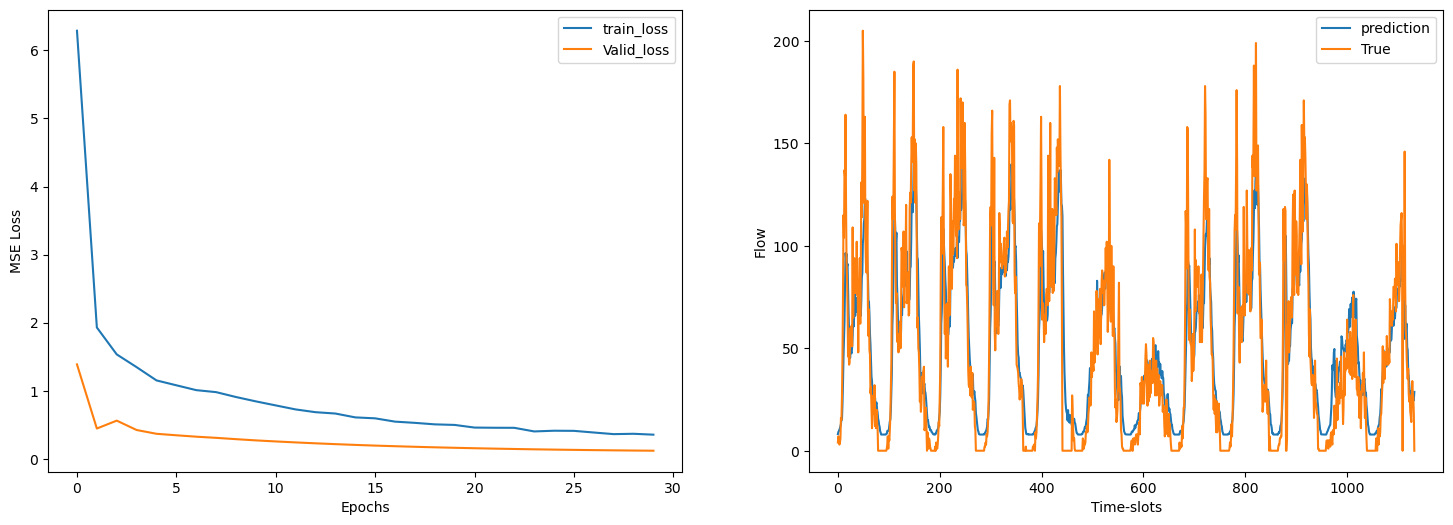

model: cnn with: 
  lr: 1e-05 
 H_dim: 16_32 
 C_outs: 1


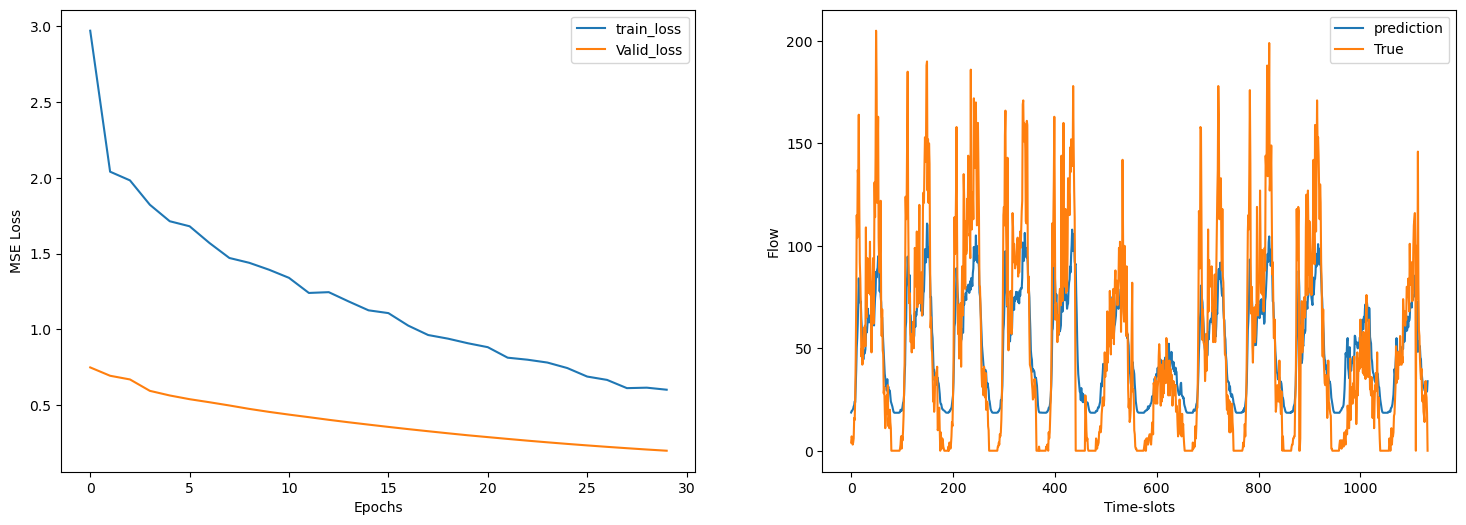

model: cnn with: 
  lr: 1e-05 
 H_dim: 16_32 
 C_outs: 32_1


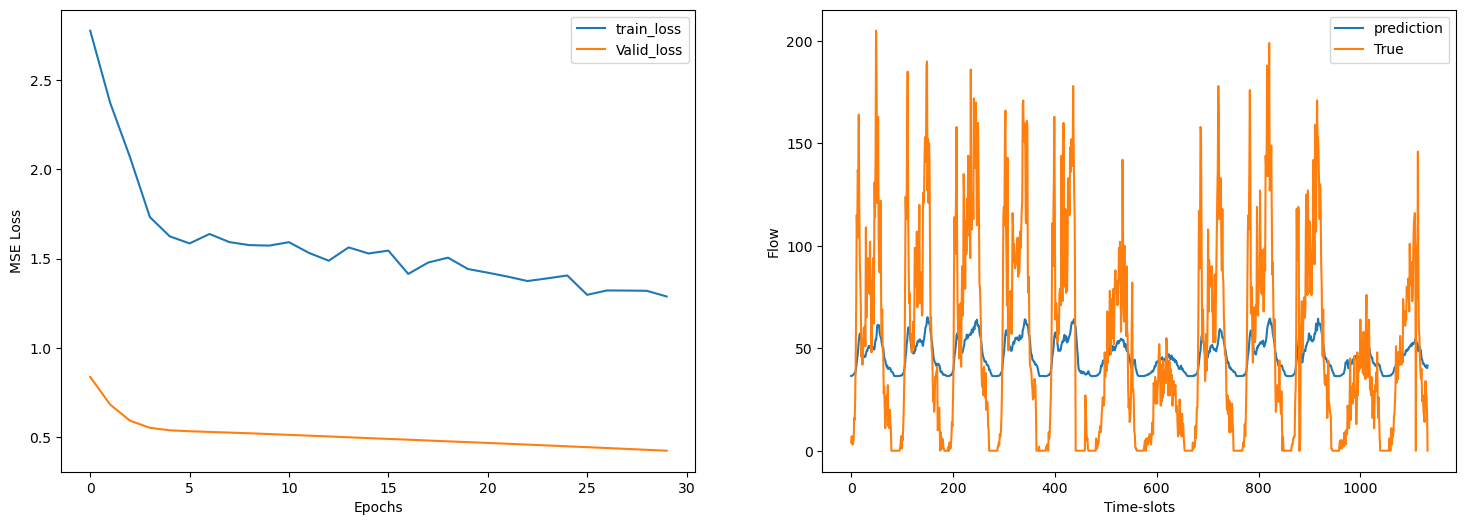

model: cnn with: 
  lr: 1e-05 
 H_dim: 16_32 
 C_outs: 16_1


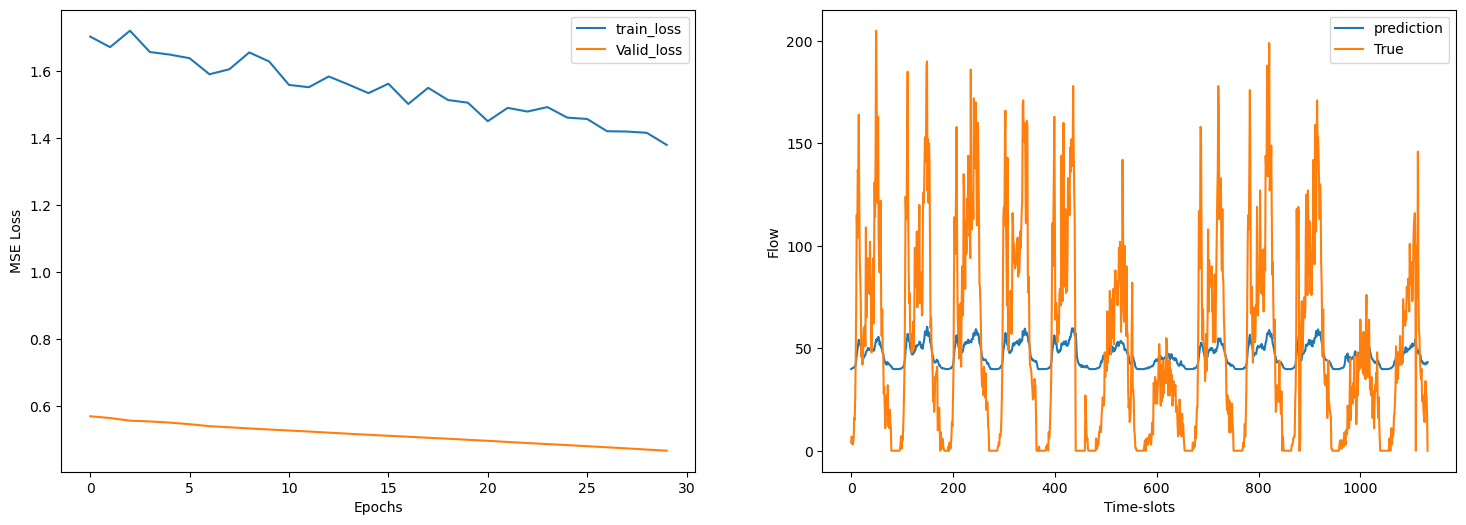

model: cnn with: 
  lr: 1e-05 
 H_dim: 32_32 
 C_outs: 1


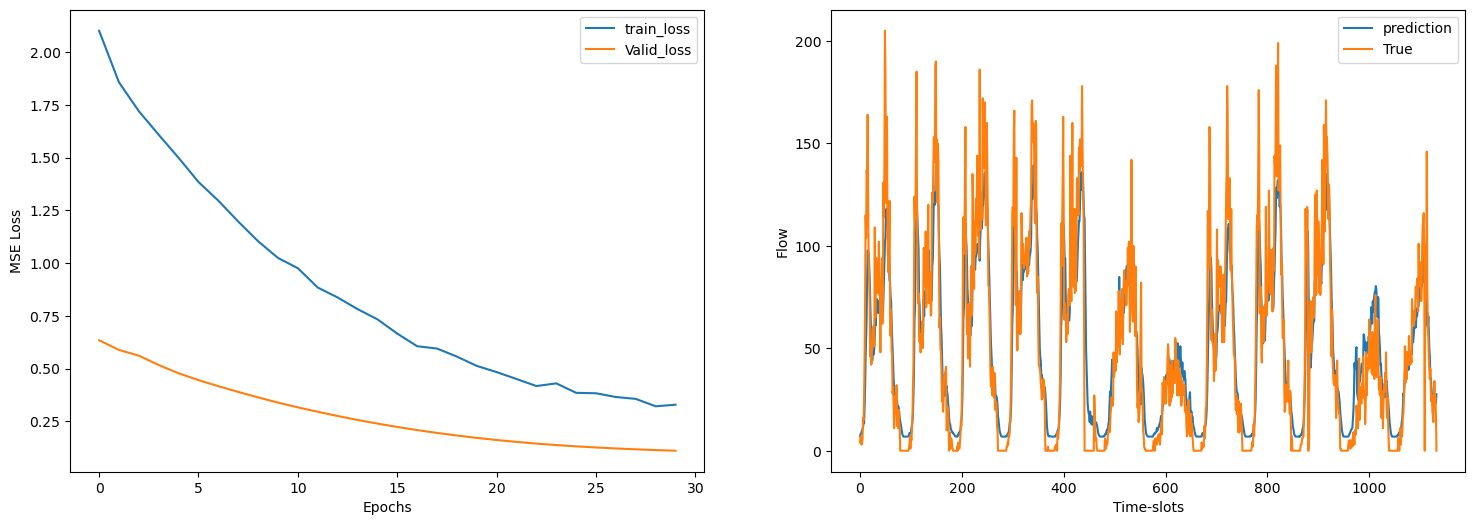

model: cnn with: 
  lr: 1e-05 
 H_dim: 32_32 
 C_outs: 32_1


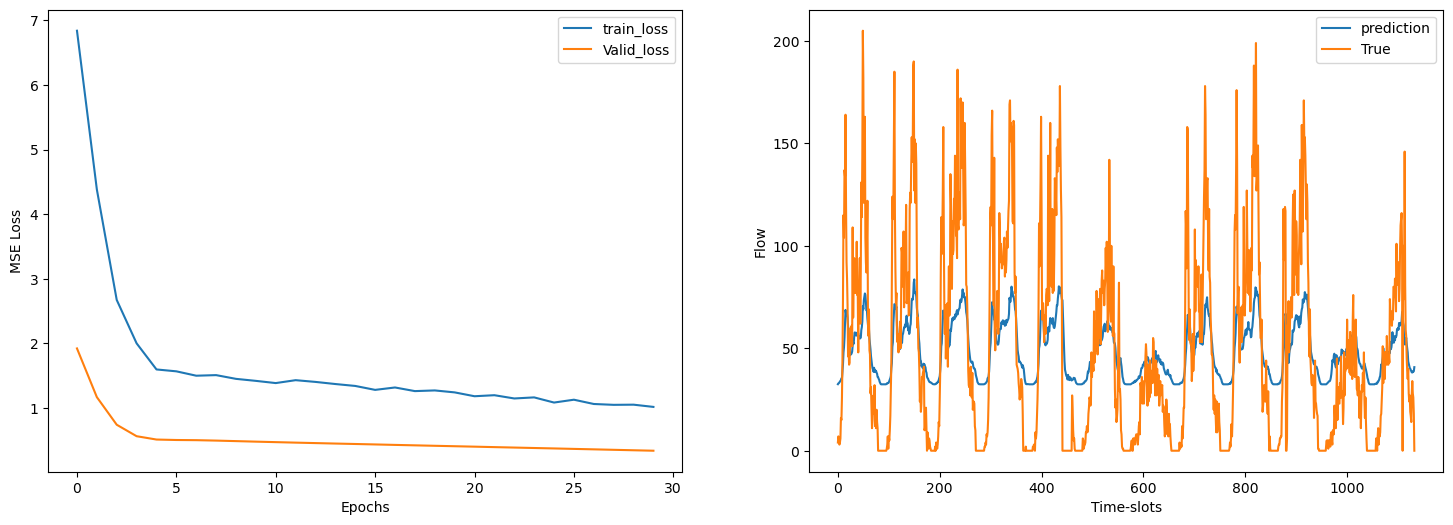

model: cnn with: 
  lr: 1e-05 
 H_dim: 32_32 
 C_outs: 16_1


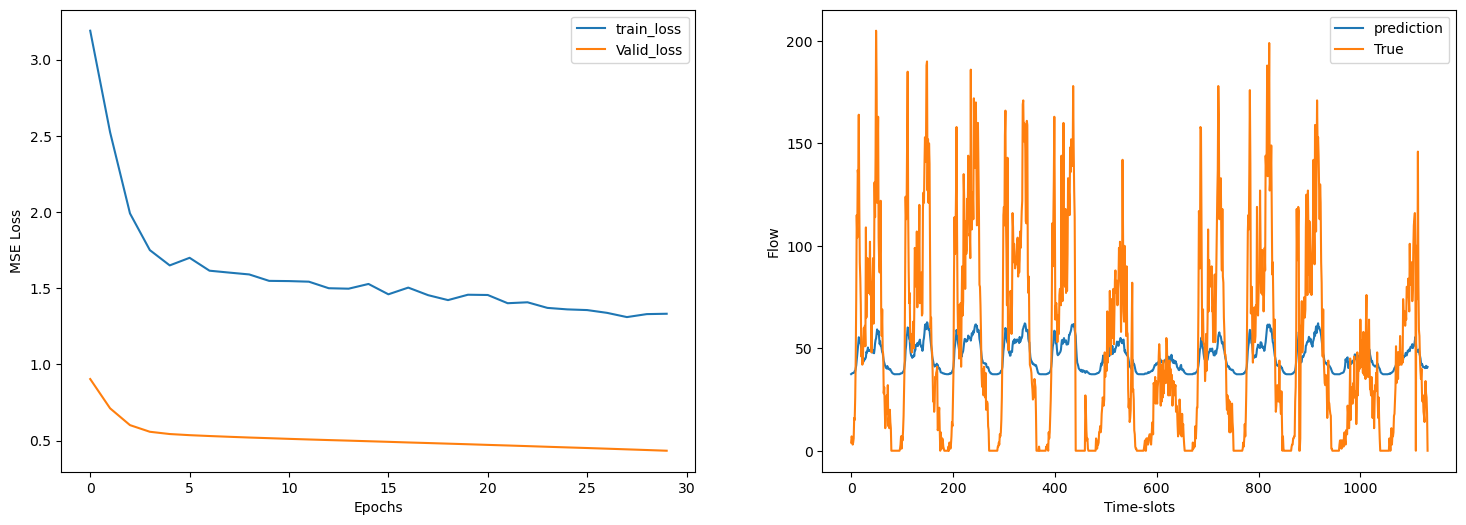

model: cnn with: 
  lr: 1e-05 
 H_dim: 16_32_16 
 C_outs: 1


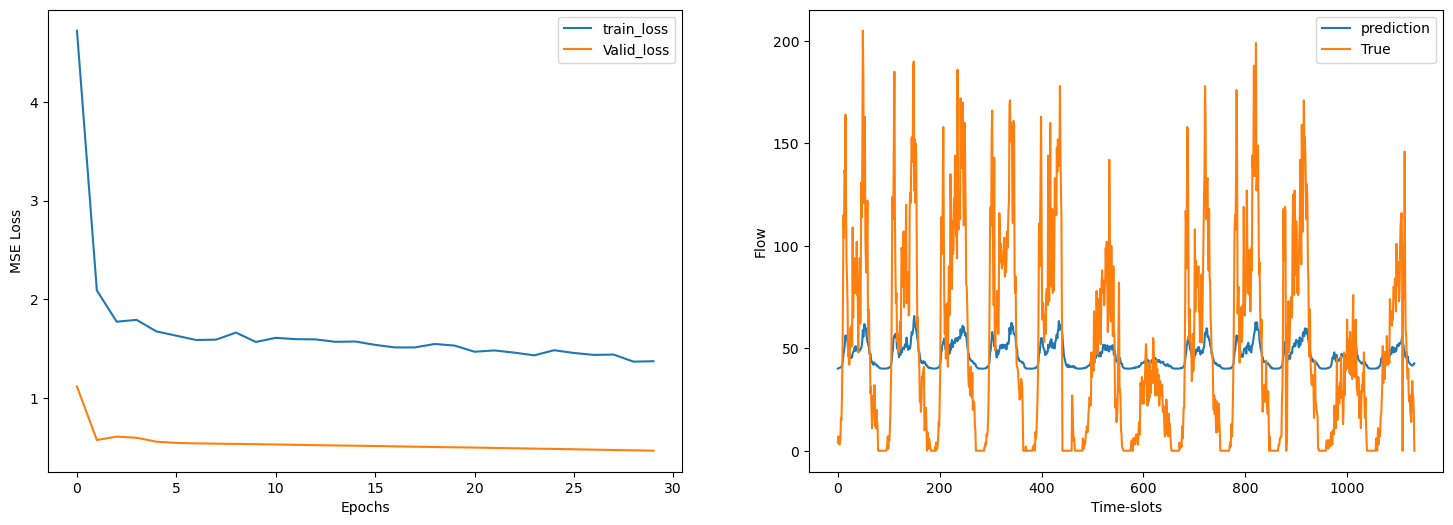

model: cnn with: 
  lr: 1e-05 
 H_dim: 16_32_16 
 C_outs: 32_1


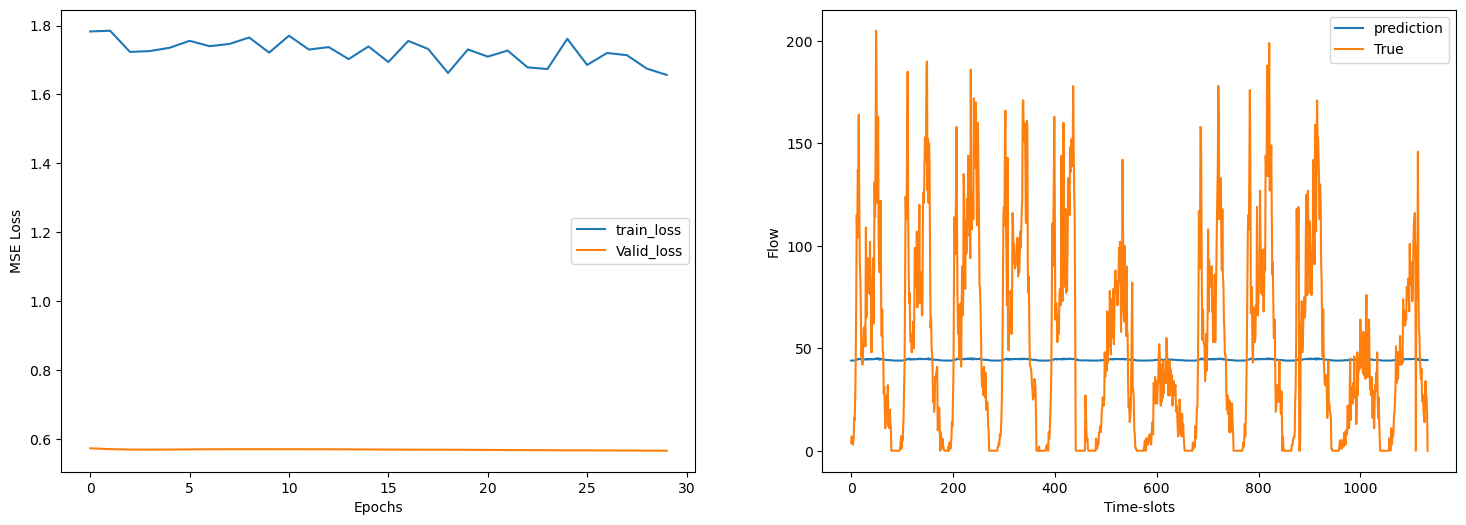

model: cnn with: 
  lr: 1e-05 
 H_dim: 16_32_16 
 C_outs: 16_1


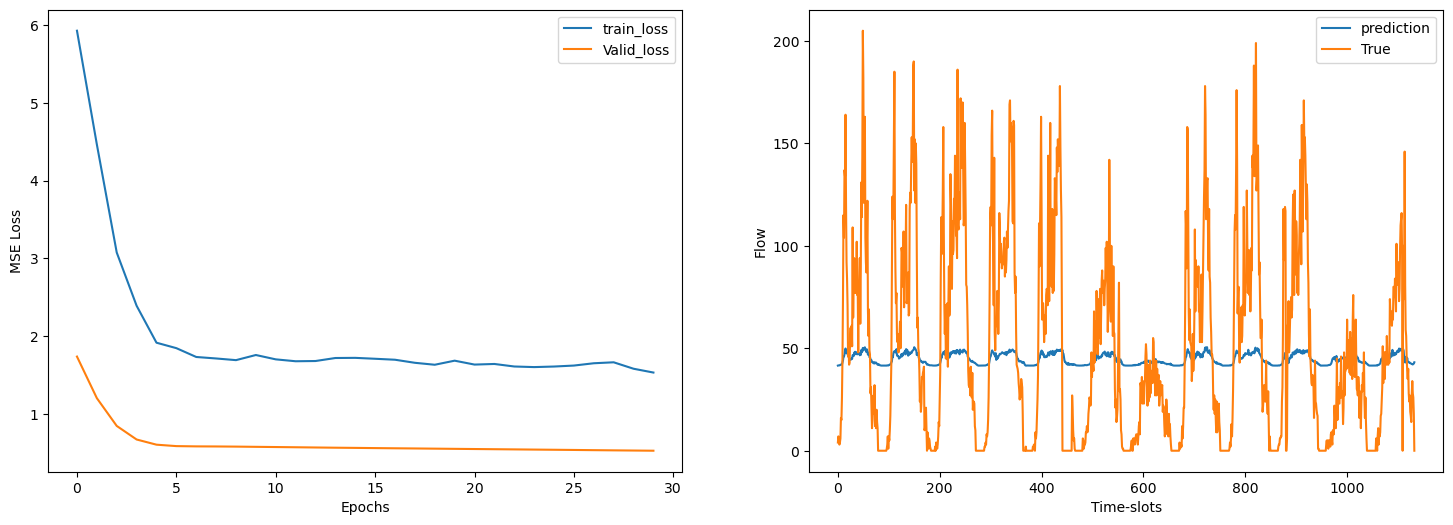

In [92]:
# Optimizer, Loss, Scheduler
for epochs in [30]:
    for lr in [1e-4,1e-5]:
        for model_name in ['cnn']:
            for H_dims in [[16],[32],[16,32],[32,32],[16,32,16]]:
                for C_outs in [[1],[32,1],[16,1]]:
                    print(f"model: {model_name} with: \n  lr: {lr} \n H_dim: {'_'.join(list(map(str,H_dims)))} \n C_outs: {'_'.join(list(map(str,C_outs)))}")
                    model = choose_model(model_name)
                    optimizer = SGD(model.parameters(),lr=lr,momentum = momentum)
                    loss_function = nn.MSELoss()  

                    trainer = Trainer(model,data_loader,epochs,optimizer,loss_function,scheduler = None)
                    trainer.train_and_valid()

                    (test_pred,Y_true,df_metrics) = testing(trainer)
                    plotting(trainer,test_pred,Y_true)


            

## HyperParameter Tuning
- add checkpoint
- K-fold cross validation 
- Tuning classique ou Ray Tuning

## Benchmark Model

## Add (simple) PI intervall 

## Basleine of PI intervall